In [ ]:
#%pip install duckdb

In [ ]:
#%run c2_workouts_dl.py --season-year 2026
%run generate_report.py --season-year 2026

In [30]:
import duckdb
cn = duckdb.connect()
cn.sql("create or replace view v_detail_workouts as select * from read_csv_auto('~/concept2/workouts/*detail*.csv')")
cn.sql("create or replace view v_summary_workouts as select * from read_csv_auto('~/concept2/workouts/*summary*.csv')")    

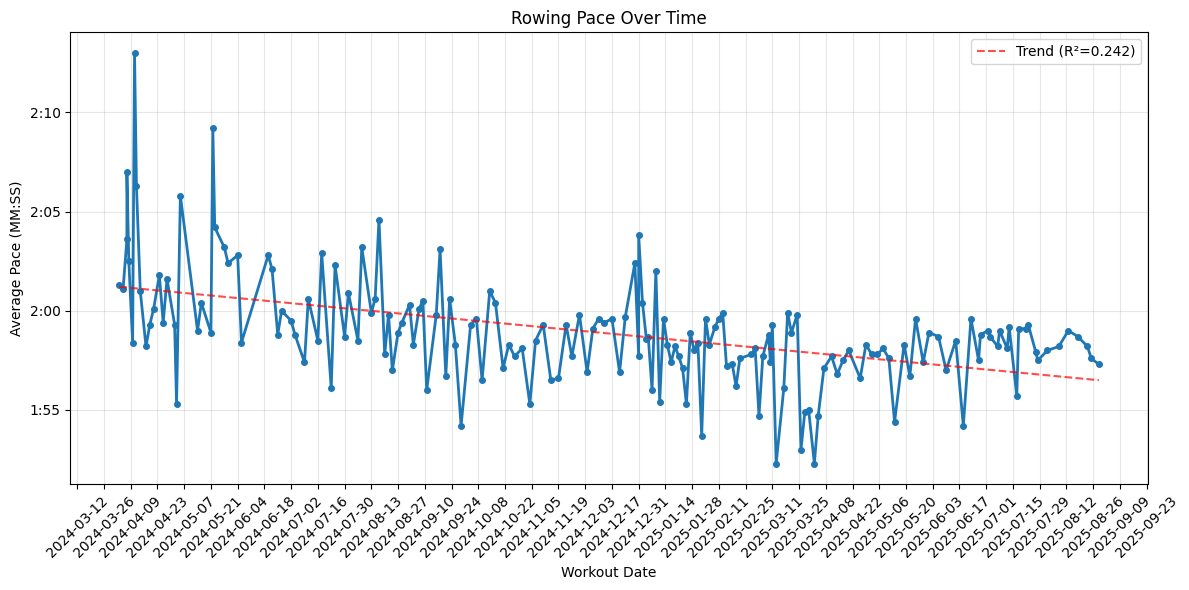

Total workouts: 175
Date range: 2024-04-03 00:00:00 to 2025-08-29 00:00:00
Best pace: 1:52
Average pace: 1:58


In [31]:
# Plot pace over time
sql_pace = """
    select "Log ID" as workout_id
        ,cast("Date" as date) as workout_dt
        ,"Work Distance" as total_meters
        ,cast('00:' || "Pace" as time) as avg_split
    from v_summary_workouts
    where 1=1
        and Type = 'RowErg'
        and "Pace" is not null
        and "Work Distance" >= 1000
    order by workout_dt
"""

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# Get the data
df_pace = cn.sql(sql_pace).df()

# Convert avg_split to seconds for plotting (easier to work with)
df_pace['pace_seconds'] = pd.to_timedelta(df_pace['avg_split'].astype(str)).dt.total_seconds()

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_pace['workout_dt'], df_pace['pace_seconds'], marker='o', linewidth=2, markersize=4)

# Format y-axis to show pace as MM:SS
def format_pace(seconds, pos):
    mins = int(seconds // 60)
    secs = int(seconds % 60)
    return f'{mins}:{secs:02d}'

ax.yaxis.set_major_formatter(plt.FuncFormatter(format_pace))

# Format x-axis dates
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
plt.xticks(rotation=45)

# Labels and title
plt.xlabel('Workout Date')
plt.ylabel('Average Pace (MM:SS)')
plt.title('Rowing Pace Over Time')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Add trend line
from scipy import stats
if len(df_pace) > 1:
    # Convert dates to numeric for trend calculation
    x_numeric = mdates.date2num(df_pace['workout_dt'])
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_numeric, df_pace['pace_seconds'])
    trend_line = slope * x_numeric + intercept
    ax.plot(df_pace['workout_dt'], trend_line, '--', color='red', alpha=0.7, label=f'Trend (R²={r_value**2:.3f})')
    plt.legend()

plt.show()

print(f"Total workouts: {len(df_pace)}")
print(f"Date range: {df_pace['workout_dt'].min()} to {df_pace['workout_dt'].max()}")
print(f"Best pace: {format_pace(df_pace['pace_seconds'].min(), 0)}")
print(f"Average pace: {format_pace(df_pace['pace_seconds'].mean(), 0)}")

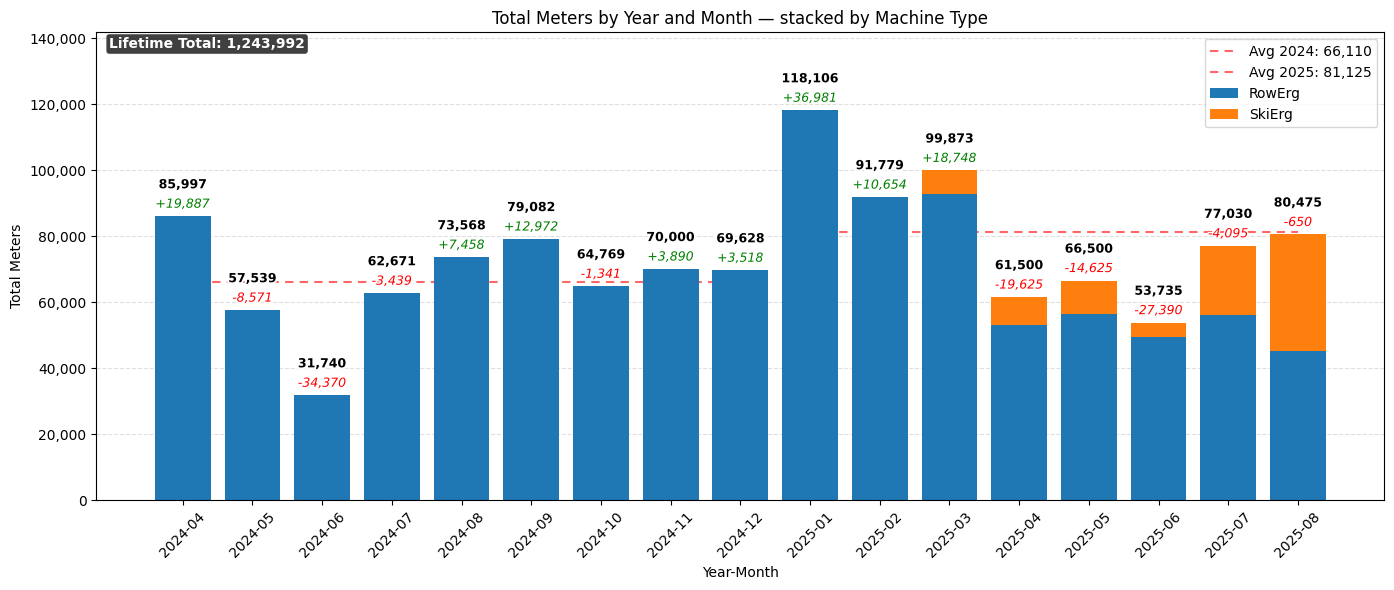

In [32]:
sql = """
    select year("Date") as workout_year
        ,type as machine_type
        ,month("Date") as workout_month
        ,sum("Work Distance") as total_meters
    from v_summary_workouts
    --where type = 'RowErg'
    group by all
"""
#import display
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FuncFormatter
import matplotlib.patheffects as pe
import matplotlib.transforms as transforms

# Query and prepare data
df = cn.sql(sql).df()
df['year_month'] = df['workout_year'].astype(str) + '-' + df['workout_month'].astype(str).str.zfill(2)

# Pivot to get one column per machine_type and rows per year_month
pivot = (
    df.sort_values(['workout_year', 'workout_month'])
      .pivot_table(index='year_month', columns='machine_type', values='total_meters', aggfunc='sum')
      .fillna(0)
)

# Ensure chronological order on the x-axis
order = pd.to_datetime(pivot.index, format='%Y-%m').argsort()
pivot = pivot.iloc[order]

x = pivot.index.tolist()
fig = plt.figure(figsize=(14,6))
ax = fig.gca()

# Stacked bars by machine type
bottom = None
for col in pivot.columns:
    ax.bar(x, pivot[col], bottom=bottom, label=col, zorder=2)
    bottom = pivot[col] if bottom is None else bottom + pivot[col]

plt.xlabel('Year-Month')
plt.ylabel('Total Meters')
plt.title('Total Meters by Year and Month — stacked by Machine Type')
plt.xticks(rotation=45)
plt.tight_layout()

# Average reference lines per year
total_by_month = pivot.sum(axis=1)
ymax = total_by_month.max()
years_series = pd.to_datetime(pivot.index, format='%Y-%m').year
years_list = years_series.tolist()
avg_by_year = total_by_month.groupby(years_series).mean()

# Draw dashed line segment spanning each year range
for yr in avg_by_year.index:
    idxs = [i for i, yv in enumerate(years_list) if yv == yr]
    if not idxs:
        continue
    yavg = avg_by_year.loc[yr]
    ax.plot([x[idxs[0]], x[idxs[-1]]], [yavg, yavg],
            color='red', linestyle=(0, (4, 3)), linewidth=1.5, alpha=0.6,
            zorder=1, label=f'Avg {yr}: {yavg:,.0f}')

# Improve readability: grid, y-axis formatting, headroom
ax.yaxis.grid(True, linestyle='--', alpha=0.4)
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, p: f'{v:,.0f}'))
ax.set_ylim(0, ymax * 1.20)  # a bit more headroom for two-line labels

# Thin x-axis labels if too many
labels = ax.get_xticklabels()
if len(labels) > 24:
    step = max(1, len(labels)//18)
    for i, label in enumerate(labels):
        label.set_visible(i % step == 0)

plt.legend()

# Lifetime total annotation in the upper-left corner
lifetime_total = int(total_by_month.sum())
ax.text(
    0.01, 0.99,
    f"Lifetime Total: {lifetime_total:,}",
    transform=ax.transAxes,
    ha='left', va='top',
    fontsize=10, fontweight='bold', color='white', zorder=5,
    bbox=dict(facecolor='black', edgecolor='none', alpha=0.75, boxstyle='round,pad=0.2')
)

# Annotate: two-line label above the bar top using fixed point offsets
for i, y in enumerate(total_by_month):
    yr = years_list[i]
    yavg = avg_by_year.loc[yr]
    delta = y - yavg

    # Top line: total
    t_total = ax.annotate(
        f"{int(y):,}",
        xy=(x[i], y),
        xytext=(0, 18),  # points above bar top
        textcoords='offset points',
        ha='center', va='bottom',
        fontsize=9, fontweight='bold', zorder=4,
    )
    t_total.set_path_effects([pe.withStroke(linewidth=3, foreground='white')])

    # Second line: delta directly below the total (vs. year average)
    color = 'green' if delta >= 0 else 'red'
    t_delta = ax.annotate(
        f"{delta:+,.0f}",
        xy=(x[i], y),
        xytext=(0, 4),  # below the total label
        textcoords='offset points',
        ha='center', va='bottom',
        fontsize=9, color=color, style='italic', zorder=4,
    )
    t_delta.set_path_effects([pe.withStroke(linewidth=2, foreground='white')])

plt.show()   


In [8]:
sql = """

    select 
        "date" as workout_date
        , "Time (seconds)" as time_seconds
        , "Distance (meters)" as distance_meters
        ,format('{:02d}:{:02d}', 
            cast(floor("Time (seconds)" / 60) as int), 
            cast(round("Time (seconds)") % 60 as int)
        ) as time_mmss
    from v_detail_workouts
    where 1=1
        and machine_type = 'rowerg'
        and "Distance (meters)" >= 5000
    qualify 1 = rank() over(partition by "date" order by "Number")
    order by "Time (seconds)" 
    limit 20

"""
cn.sql(sql).show()

┌──────────────┬──────────────┬─────────────────┬───────────┐
│ workout_date │ time_seconds │ distance_meters │ time_mmss │
│     date     │    double    │     double      │  varchar  │
├──────────────┼──────────────┼─────────────────┼───────────┤
│ 2025-03-13   │       1126.2 │          5005.3 │ 18:46     │
│ 2025-06-19   │       1145.0 │          5002.6 │ 19:05     │
│ 2025-03-04   │       1147.9 │          5000.0 │ 19:08     │
│ 2025-05-14   │       1149.0 │          5008.8 │ 19:09     │
│ 2025-04-04   │       1150.8 │          5003.9 │ 19:11     │
│ 2024-11-04   │       1151.7 │          5006.1 │ 19:12     │
│ 2025-01-25   │       1156.4 │          5008.6 │ 19:16     │
│ 2025-01-07   │       1164.2 │          5005.5 │ 19:24     │
│ 2025-01-23   │       1165.0 │          5002.6 │ 19:25     │
│ 2025-02-20   │       1165.0 │          5007.0 │ 19:25     │
│ 2025-03-17   │       1165.8 │          5005.8 │ 19:26     │
│ 2024-12-04   │       1167.7 │          5002.5 │ 19:28     │
│ 2024-1

In [5]:
sql = """
    select
        year("date") as year,
        month("date") as month,
        sum("Work Distance") as total_meters
    from v_summary_workouts
    group by all
    order by year, month

"""

cn.sql(sql).show()

┌───────┬───────┬──────────────┐
│ year  │ month │ total_meters │
│ int64 │ int64 │    int128    │
├───────┼───────┼──────────────┤
│  2024 │     4 │        85997 │
│  2024 │     5 │        57539 │
│  2024 │     6 │        31740 │
│  2024 │     7 │        62671 │
│  2024 │     8 │        73568 │
│  2024 │     9 │        79082 │
│  2024 │    10 │        64769 │
│  2024 │    11 │        70000 │
│  2024 │    12 │        69628 │
│  2025 │     1 │       118106 │
│  2025 │     2 │        91779 │
│  2025 │     3 │        99873 │
│  2025 │     4 │        61500 │
│  2025 │     5 │        66500 │
│  2025 │     6 │        53735 │
│  2025 │     7 │        77030 │
│  2025 │     8 │        80475 │
├───────┴───────┴──────────────┤
│ 17 rows            3 columns │
└──────────────────────────────┘



In [ ]:
sql = """
    select "Number" as workout_id
        ,sum("Distance (meters)")
    from v_detail_workouts
    limit 10
"""
cn.sql(sql)

┌────────┬────────────────┬───────────────────┬────────────────┬───────┬────────┬─────────────┬────────────┬────────┬────────────┬──────────────┐
│ Number │ Time (seconds) │ Distance (meters) │ Pace (seconds) │ Watts │ Cal/Hr │ Stroke Rate │ Heart Rate │ season │    date    │ machine_type │
│ int64  │     double     │      double       │     double     │ int64 │ int64  │    int64    │   int64    │ int64  │    date    │   varchar    │
├────────┼────────────────┼───────────────────┼────────────────┼───────┼────────┼─────────────┼────────────┼────────┼────────────┼──────────────┤
│      1 │            0.7 │               2.1 │            0.0 │  NULL │   NULL │        NULL │       NULL │   2024 │ 2024-04-03 │ rowerg       │
│      2 │            2.7 │               8.8 │          169.5 │    72 │    547 │        NULL │       NULL │   2024 │ 2024-04-03 │ rowerg       │
│      3 │            5.2 │              17.1 │          150.1 │   103 │    656 │          27 │       NULL │   2024 │ 2024-0